## 4.3 앙상블 학습(Ensemble Learning) 개요
- 여러 개의 Classifier를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법
- Voting, Bagging, Boosting (+ Stacking)
  - 대표적인 Bagging: Random Forest Algorithm
  - 대표적인 Boosting: Aida boosting, gradiant boosting(gbm), XGBoost, LightGBM etc
  - 정형 데이터의 분류나 회귀에서는 GBM 부스팅 계열의 앙상블이 전반적으로 높은 예측 성능을 보임
  

**특징**
- 상이한 특성을 가진 모델들을 결합해 단일 모델의 약점을 보완
- 랜덤 포레스트, 뛰어난 부스팅 알고리즘들은 모두 결정 트리 알고리즘을 기반으로 적용
- 결정 트리의 단점인 과적합을 수십~수천 개의 분류기를 결합함으로 보완하고 직관적인 분류 기준을 강화시킬 수 있음

### Voting Classifier
- 여러 개의 분류기가 투표를 통해 치종 예측 결과를 결정하는 방식
- 보팅과 배깅
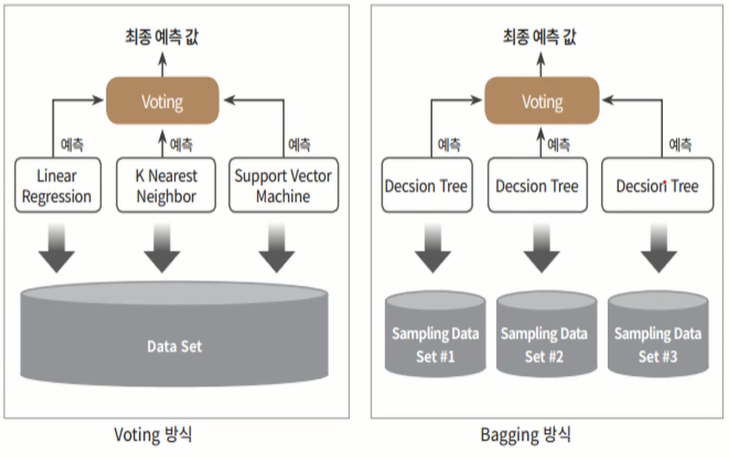

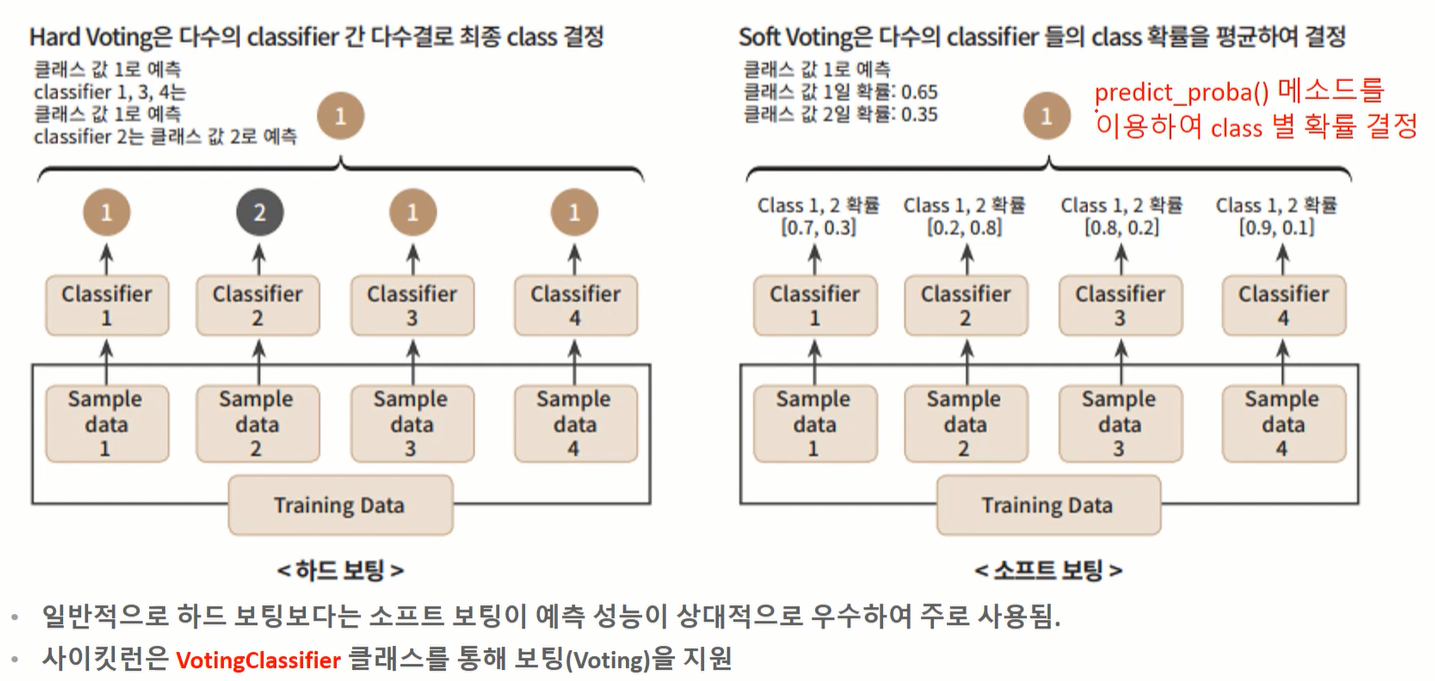

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


**VotingClassifier로 개별모델은 로지스틱 회귀와 KNN을 보팅 방식으로 결합하고 성능 비교**

In [4]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf), # estimator's'라 리스트 형
                                       ('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


## 4.4 Random Forest
- 배깅의 대표적인 알고리즘
- 앙상블 알고리즘 중비교적 빠른 수행 속도와 높은 예측 성능을 보이고 있음
- 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최정적으로 모든 분류기가 보팅을 통해 예측 결정
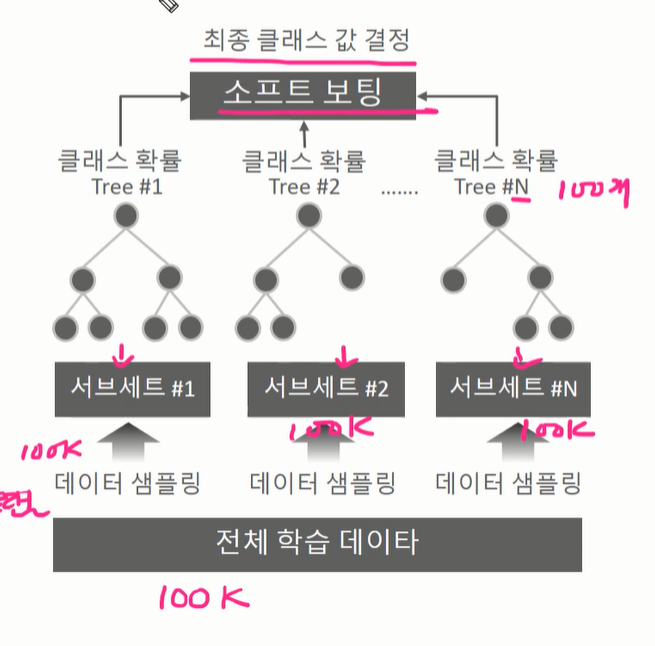

※ Bagging (Bootstrap aggregating)
- 개별 분류기의 기반 알고리즘은 '결정 트리'이지만,
<br>개별 트리가 학습하는 데이터 셋은 일부가 중첩되게 샘플링한 데이터 셋
<br>= 부트스트래핑 분할 방식
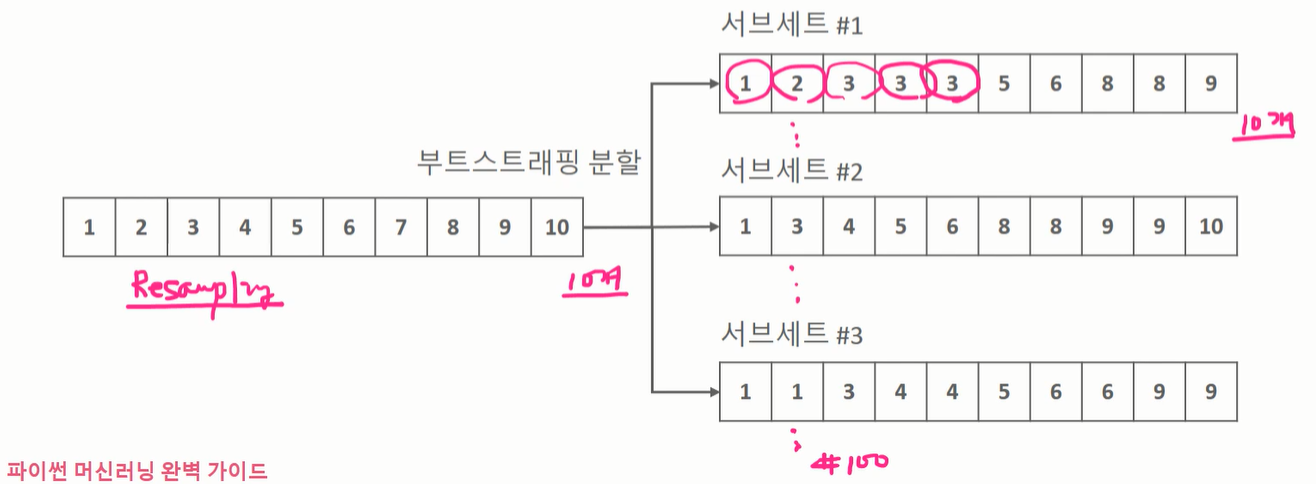

- n_estimatiors: 랜덤 포레스트에서 결정 트리의 개수 지정 (default=100)
- max_features: 결정 트리의 max_features와 같음 (default=auto=sqrt(전체 피처 개수))
- min_weight_fraction_leaf: 리프의 가중치를 결정 (중요도 파악)
- max_leaf_nodes: 리프의 개수 제한
- class_weight: 불균형 데이터가 균형적으로 분류되도록 가중치를 부여
- oob_score: 부트스트래핑을 하다 보면 개별 학습기에서 빠지는 데이터가 있는데, 그 데이터로 평가하면서 out-of-back 계산하는 매커니즘을 수행할 것인지 (default=false)

In [1]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=8)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9196


In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
# n_jobs=-1 : means using all processors
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9165


In [13]:
rf_clf1 = RandomForestClassifier(n_estimators=100,  min_samples_leaf=6, max_depth=16,
                                 min_samples_split=2, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9260


In [14]:
ftr_importances_values = rf_clf1.feature_importances_
pd.Series(ftr_importances_values,index=X_train.columns)

tBodyAcc-mean()-X                       0.000098
tBodyAcc-mean()-Y                       0.000172
tBodyAcc-mean()-Z                       0.000081
tBodyAcc-std()-X                        0.004048
tBodyAcc-std()-Y                        0.000235
                                          ...   
angle(tBodyGyroMean,gravityMean)        0.000255
angle(tBodyGyroJerkMean,gravityMean)    0.000293
angle(X,gravityMean)                    0.035312
angle(Y,gravityMean)                    0.029013
angle(Z,gravityMean)                    0.009483
Length: 561, dtype: float64

In [15]:
# feature importances 만들 때 주로 쓰는 코드 
ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_importances.sort_values(ascending=False)[:20]

angle(X,gravityMean)               0.035312
tGravityAcc-mean()-Y               0.033729
tGravityAcc-min()-X                0.030276
angle(Y,gravityMean)               0.029013
tGravityAcc-max()-X                0.027538
tGravityAcc-mean()-X               0.024708
tGravityAcc-energy()-X             0.024389
tGravityAcc-min()-Y                0.023339
tGravityAcc-max()-Y                0.021011
fBodyAccJerk-bandsEnergy()-1,8     0.018636
tGravityAcc-energy()-Y             0.015461
tBodyAcc-max()-X                   0.013750
tBodyAccJerk-entropy()-X           0.013433
tGravityAcc-arCoeff()-Z,1          0.013150
tGravityAcc-max()-Z                0.013125
fBodyAccMag-energy()               0.012262
tGravityAcc-energy()-Z             0.010683
fBodyAccJerk-bandsEnergy()-1,16    0.010095
fBodyAcc-mad()-X                   0.010036
angle(Z,gravityMean)               0.009483
dtype: float64

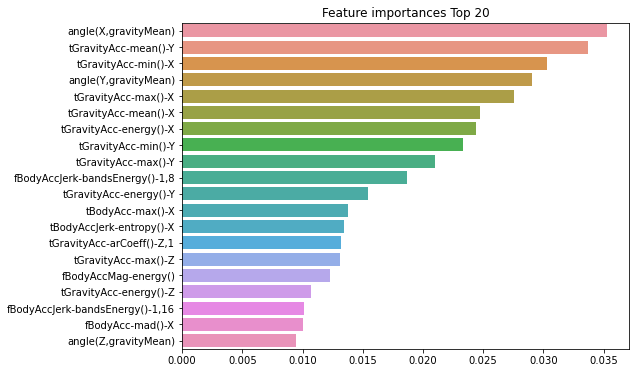

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

- Boosting Algorithm: 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터나 학습 트리에 가중치를 부여함으로 오류를 개선하며 학습하는 방식
- 에이다 부스팅 학습/예측 프로세스
  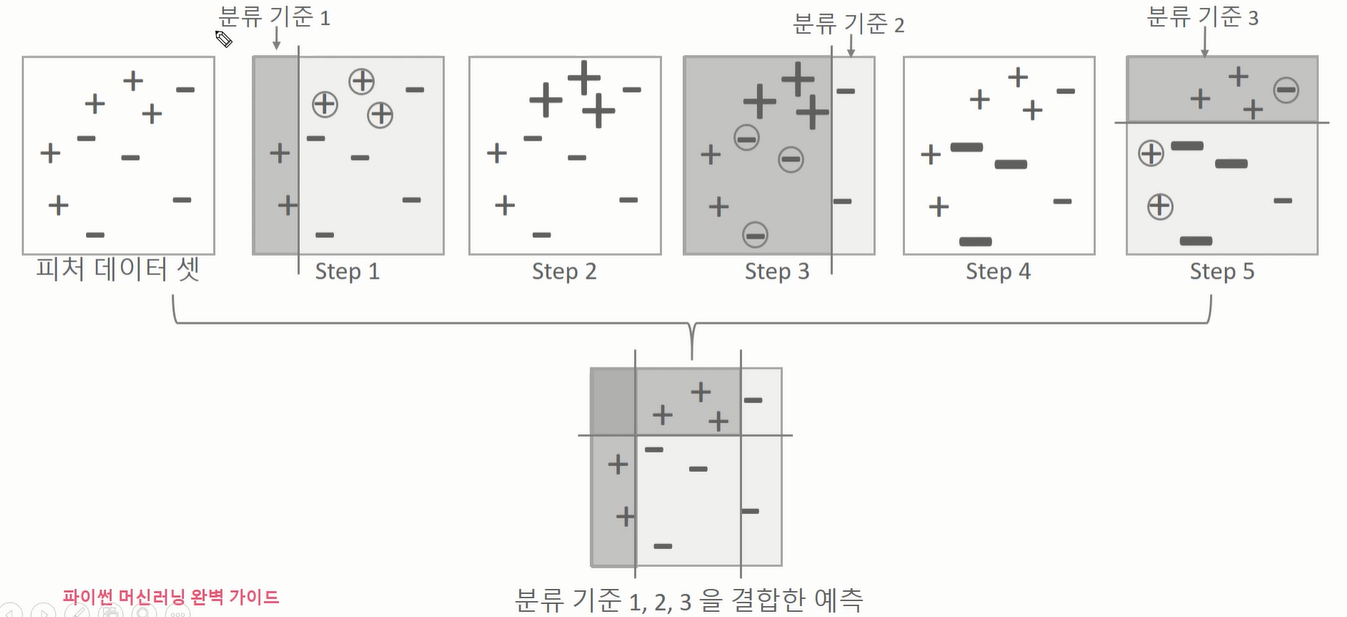
  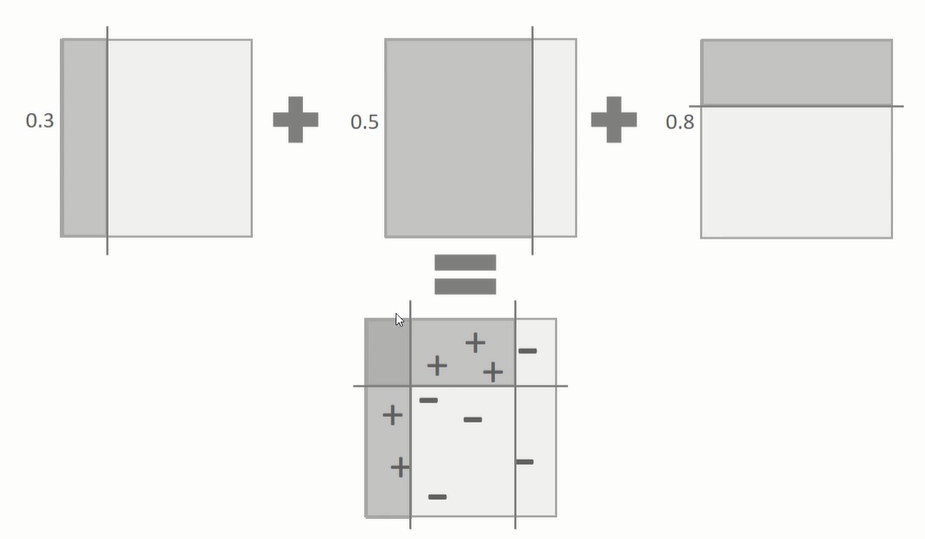
  각 분류마다 서로 다른 가중치 값을 부여해 최종 가중치 합으로 분류
  
## 4.5 GBM(Gradient Boosting Machine)
- 에이다 부스트와 유사하나 가중치 업데이트를 **Gradient Descent**를 이용하는 것이 큰 차이
  - Gradient Descent: 오류 값(loss)은 '실제 값 - 예측 값', 오류식 h(x) = y = F(x)를 최소화하는 방향으로 가중치 값을 반복 업데이트 
  - 반복 수행으로 통해 오류를 최소화할 수 있도록 가중치가 업데이트된 값을 도출하는 기법으로 머신러닝에서 중요한 기법 중 하나
  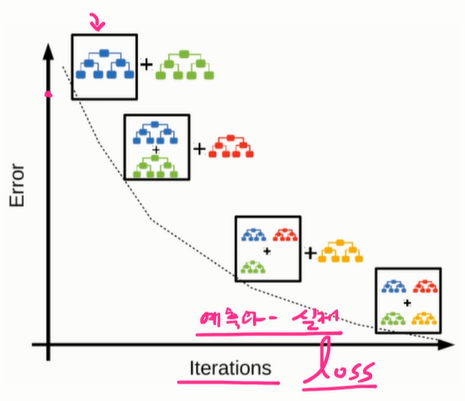
  
### 주요 하이퍼 파라미터 및 튜닝
- loss: gradient descent에서 사용할 loss function을 지정 (default=deviance)
- learning_rate: gbm이 학습을 진행할 때마다 적용하는 학습률 (default=0.1)
  <br>weak learner가 순차적으로 오류 값을 보정해 나가는 데 적용하는 계수
  * 작은 값을 적용할수록 업데이트되는 값이 작아져 최소 오류 값을 찾아 예측 성능이 향상될 가능성이 높다. 하지만 시간이 **오래 걸리고**, 모든 반복이 완료되어도 최소 오류 값을 **찾지 못할 수 있다**.
- n_estimators: weak learner의 개수 (default=100)
- subsample: weak learner가 학습에 사용하는 데이터의 샘플링 비율 (default=1=all)
  <br>과적합이 염려되면 1보다 작게 설정한다.

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))


GBM 정확도: 0.9389
GBM 수행 시간: 616.5 초 


In [ ]:
### 아래는 강의에서 설명드리지는 않지만 GridSearchCV로 GBM의 하이퍼 파라미터 튜닝을 수행하는 예제 입니다. 
### 사이킷런이 1.X로 업그레이드 되며서 GBM의 학습 속도가 현저하게 저하되는 문제가 오히려 발생합니다. 
### 아래는 수행 시간이 오래 걸리므로 참고용으로만 사용하시면 좋을 것 같습니다. 
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [ ]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))